In [1]:
# !wget -qO ./OLIDv1.0.zip https://sites.google.com/site/offensevalsharedtask/olid/OLIDv1.0.zip
# !mkdir -p ./data
# !unzip -qqo ./OLIDv1.0.zip -d data/
# !wget -qO ./contractions.py "https://raw.github.com/neerajvashistha/msc_ai_sem1/master/Lab/NLP/Lab 2 (Assessed)-20191014/contractions.py"
# !wget -qO ./emo_unicode.py   "https://raw.githubusercontent.com/NeelShah18/emot/master/emot/emo_unicode.py"
# !pip -q install ekphrasis 
# !pip -q install emoji --upgrade
# !pip -q install pyspellchecker
# !pip -q install dask[dataframe] 

In [28]:
import pandas as pd
from contractions import general_contraction
from emo_unicode import EMOTICONS_EMO
from emo_unicode import EMOTICONS
import re
import string
from ekphrasis.classes.segmenter import Segmenter
import emoji
from ekphrasis.classes.tokenizer import SocialTokenizer
import string,re
import time

punct = string.punctuation

punct = string.punctuation.replace('\\','')
punct2 = punct.replace('!','').replace('?','')+'#'

from spellchecker import SpellChecker
seg = Segmenter() 
spell = SpellChecker()
social_tokenizer = SocialTokenizer(lowercase=False).tokenize


df_tweet = pd.read_csv('./data/olid-training-v1.0.tsv',sep='\t')#.head(1000)

Reading english - 1grams ...
Reading english - 2grams ...


In [3]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
id           13240 non-null int64
tweet        13240 non-null object
subtask_a    13240 non-null object
subtask_b    4400 non-null object
subtask_c    3876 non-null object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [29]:
def _replace_mul_special_char(astr):
#     return [re.sub("["+i+"]+", i, astr) if i in astr else x for x in punct]
    def _replace(string, char): 
#         print(char)
        pattern = "\\"+ char + '{2,}'  
#         print(pattern)
        string = re.sub(pattern, char, string) 
        return string 

    for i in punct:
        if i in astr:
            astr = _replace(astr,i)
    return astr

# s = ["so i believe :::::::-)) that :-]]",'but what i say :-) !!! I lknow  ://','0 we wil see when the time comes :\\']
# for i in s:
#     print(_replace_mul_special_char(i))
     

In [30]:
def _clean_list(alist):
    alist = ' '.join(alist).split(' ')
    for t in range(len(alist)):
        if len(alist[t].split(' ')) > 0:
            alist[t] = re.sub('[^A-Za-z*]+', ' ', ' '.join(alist[t].split())).strip()
    return list(filter(None, alist))

# a = ['', 'canada', 'does       not', 'need', 'another', 'cuck!', 'we', 'already', 'have', 'enough', '# looney   left', '#   liberals', 'f*   king', 'up', 'our', 'great', 'country   !', '#q   proofs', '# trudeau must go']
# a = ['']
# _clean_list(a)

In [31]:
# Lowercasing
# Removing URLs, @USER, all the following charachters “ :. , — ˜ ”, digits and single quotation marks except for abbreviations and possessors (e.g. u’re → u’re, but about’ → about)
# !@#$%^&*()[]{};:,./<>?\|`~-=_+
# Using ‘=’, ‘!’, ‘?’ and ‘/’ as token splitters (e.g. something!important → something important)
# Parsing hashtags (See Christos Baziotis et. al. 2017)




def _replace_use_dict(adict,tokens):    
    return [seg.segment(adict.get(n, n)) if len(n)>5 else adict.get(n, n) for n in tokens ]

def _spell_correction(alist):
    return map(lambda word: word if word not in spell else spell.correction(word), alist)


punct2 = punct.replace('!','').replace('?','')+'#'

def preprocessing(x):
    x = x.replace('@USER','').replace('URL','').replace('’',"'")
    x = str(x).lower()
    x = _replace_mul_special_char(x)
    x = emoji.demojize(x)
    xt = x.split(' ')
    xt1 = _replace_use_dict(general_contraction,xt)    
    xt2 = _replace_use_dict(EMOTICONS_EMO,xt1)
    xt3 = _replace_use_dict(EMOTICONS,xt2)
    xt4 = _clean_list(xt3)
    xtf = ' '.join(xt4).split(' ')
    return xtf

print(df_tweet.tweet[9])
print(preprocessing(df_tweet.tweet[9]))
# for i in range(100):
#     print(preprocessing(df_tweet.tweet[i]))


@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo
['canada', 'does', 'not', 'need', 'another', 'cuck', 'we', 'already', 'have', 'enough', 'looney', 'left', 'liberals', 'f*', 'king', 'up', 'our', 'great', 'country', 'q', 'proofs', 'trudeau', 'must', 'go']


In [7]:
# startt = time.time()
# df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: preprocessing(x['tweet']),axis=1)
# endt = time.time()
# print('total time: ', endt-startt)

In [32]:
startt = time.time()
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
nCores = cpu_count() - 1

# my_df.apply(lambda x: nearest_street(x.lat,x.lon),axis=1)
# df_tweet['tweet'] = df.apply(lambda x: preprocessing(x['tweet']),axis=1)

df_tweet['tweet_pr_st1']  = dd.from_pandas(df_tweet,npartitions=nCores).\
               map_partitions(
                  lambda df : df.apply(
                     lambda x : preprocessing(x.tweet),axis=1)).\
               compute(scheduler='processes')
endt = time.time()
print('total time: ', endt-startt)

total time:  541.0534737110138


In [33]:
df_tweet.shape

(13240, 6)

In [36]:
for i in df_tweet['tweet_pr_st1'][0:100]

,id,tweet,subtask_a,subtask_b,subtask_c,tweet_pr_st1
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"[she, should, ask, a, few, native, americans, ..."
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"[go, home, you, are, drunk, maga, trump, oncom..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,"[amazon, is, investigating, chinese, employees..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"[someone, should, vetaken, this, piece, of, sh..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"[obama, wanted, liberals, amp, illegals, to, m..."
...,...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,"[sometimes, i, get, strong, vibes, from, peopl..."
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,"[benidorm, white, heavy, check, mark, creamfie..."
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,"[and, why, report, this, garbage, we, do, not,..."
13238,27429,@USER Pussy,OFF,UNT,NaN,[pussy]


In [10]:
# df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: ' '.join(x.tweet_pr_st1),axis = 1)

In [37]:
df_tweet.to_csv('data/processed_tweet.csv',index=False)

In [157]:
# import pandas as pd
df_tweet = pd.read_csv("data/processed_tweet.csv")
import ast
df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st1),axis =1)

In [158]:
# !wget https://raw.githubusercontent.com/neerajvashistha/msc_ai_sem1/master/Lab/NLP/processed_tweet.txt
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/nv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nv/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/nv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# import pandas as pd
# import numpy as np
# df_tweet = pd.read_csv('./processed_tweet.txt')
# df_tweet.info()

In [159]:
from nltk.corpus import stopwords
import re
def remove_stopwords(tweet):    
    stop = set(stopwords.words("english"))
    other = ['user']
    data = [w for w in tweet if w not in stop and not re.match(r"[^a-zA-Z\d\s]+", w) and w not in other and len(w) >= 2 ]
    return data

In [160]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from nltk import pos_tag
from nltk.corpus import wordnet
def get_pos(word):
    tag = pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(tweet):
    if tweet:
        data = [wnl.lemmatize(str(word), pos=get_pos(str(word))) for word in tweet]
        return data
    else:
        return []
    
# tweet = df_tweet_task_a.tweet[21]
# print(tweet)
# print(remove_stopwords(tweet))
# print(lemmatize(tweet))

In [161]:
df_tweet['tweet_pr_st2'] = df_tweet.apply(lambda x: lemmatize(remove_stopwords(x.tweet_pr_st1)),axis =1)

In [162]:
df_tweet[df_tweet['tweet_pr_st2'].str.len()<=0].count()

id              52
tweet           52
subtask_a       52
subtask_b        1
subtask_c        1
tweet_pr_st1    52
tweet_pr_st2    52
dtype: int64

In [163]:
for i,k in enumerate(list(df_tweet["tweet_pr_st2"].str.len())):
    if k<=0:
        print(df_tweet['tweet'][i],"**",df_tweet['tweet_pr_st1'][i],"**",df_tweet['tweet_pr_st2'][i],df_tweet['subtask_a'][i],k)
import numpy as np
df_tweet['len_tweet_pr_st2'] = df_tweet["tweet_pr_st2"].str.len()
print("Removing not useful instances", df_tweet[df_tweet['len_tweet_pr_st2']<=0].id.count())
print("Not useful include ", df_tweet[df_tweet['len_tweet_pr_st2']<=0].subtask_b.count(),' offensive category instances')
drop_indices = df_tweet[df_tweet['len_tweet_pr_st2']<=0].index
df_tweet.drop(drop_indices , inplace=True)

@USER he is ** ['he', 'is'] ** [] NOT 0
@USER @USER He is. ** ['he', 'is'] ** [] NOT 0
@USER He IS in!!! ** ['he', 'is', 'in'] ** [] NOT 0
@USER @USER @USER they aren't.... ** ['they', 'are', 'n', 't'] ** [] NOT 0
@USER As they should be ** ['as', 'they', 'should', 'be'] ** [] NOT 0
@USER Here he is: @USER ** ['here', 'he', 'is'] ** [] NOT 0
@USER @USER Me too! ** ['me', 'too'] ** [] NOT 0
@USER you are here! ** ['you', 'are', 'here'] ** [] NOT 0
@USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER She is. ** ['she', 'is'] ** [] NOT 0
@USER It’s more what she does than who she is ** ['it', 'is', 'more', 'what', 'she', 'does', 'than', 'who', 'she', 'is'] ** [] OFF 0
@USER There she is... URL ** ['there', 'she', 'is'] ** [] NOT 0
@USER He is ** 

In [20]:
# df_tweet['subtask_a'][8347]

Subtask A categories ['OFF' 'NOT']
Subtask A offensive tweet count 4399
Subtask A Non offensive tweet count 8789
Total trainable tweets 13188


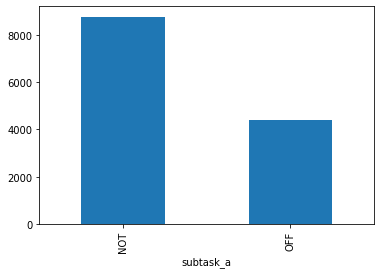

In [164]:
print('Subtask A categories',df_tweet['subtask_a'].unique())
print('Subtask A offensive tweet count',df_tweet[df_tweet['subtask_a']=='OFF'].subtask_a.count())
print('Subtask A Non offensive tweet count',df_tweet[df_tweet['subtask_a']=='NOT'].subtask_a.count())
print('Total trainable tweets',df_tweet['subtask_a'].count())
df_tweet.groupby(['subtask_a']).count()['id'].plot.bar()

Subtask B categories ['UNT' 'TIN' nan] total
Subtask B untargetted offensive tweet count  524
Subtask B targetted offensive tweet count 3875
Subtask B Non offensive tweet count 8789
Subtask B Total trainable tweets 4399


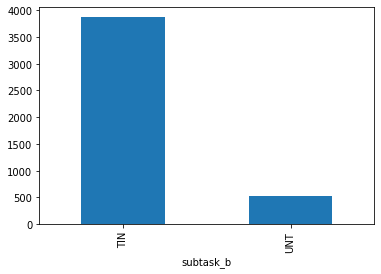

In [165]:
print('Subtask B categories',df_tweet['subtask_b'].unique(),'total')
print('Subtask B untargetted offensive tweet count ',df_tweet[df_tweet['subtask_b']=='UNT'].subtask_b.count())
print('Subtask B targetted offensive tweet count',df_tweet[df_tweet['subtask_b']=='TIN'].subtask_b.count())
print('Subtask B Non offensive tweet count',df_tweet['subtask_b'].isnull().sum())
print('Subtask B Total trainable tweets',df_tweet['subtask_b'].isin(['UNT','TIN']).sum())
df_tweet.groupby(['subtask_b']).count()['id'].plot.bar()

Subtask C categories [nan 'IND' 'OTH' 'GRP']
Subtask C targetted indiviual offensive tweet count 2406
Subtask C targetted group offensive tweet count 1074
Subtask C targetted other offensive tweet count 395
Subtask C Non offensive tweet count 9313
Subtask C Total trainable tweets 3875


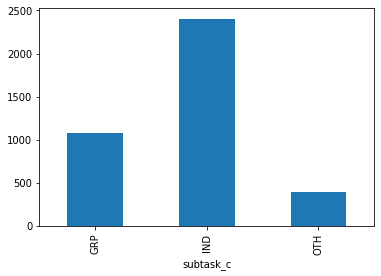

In [166]:
print('Subtask C categories',df_tweet['subtask_c'].unique())
print('Subtask C targetted indiviual offensive tweet count',df_tweet[df_tweet['subtask_c']=='IND'].subtask_c.count())
print('Subtask C targetted group offensive tweet count',df_tweet[df_tweet['subtask_c']=='GRP'].subtask_c.count())
print('Subtask C targetted other offensive tweet count',df_tweet[df_tweet['subtask_c']=='OTH'].subtask_c.count())
print('Subtask C Non offensive tweet count',df_tweet['subtask_c'].isnull().sum())
print('Subtask C Total trainable tweets',df_tweet['subtask_c'].isin(['IND','GRP','OTH']).sum())
df_tweet.groupby(['subtask_c']).count()['id'].plot.bar()

In [167]:
#0 - Not offensive
#1 - Offensive untargeted
#2 - Offensive targeted indiviualds
#3 - Offensive targeted groups 
#4 - Offensive targeted others

df_tweet['subtask_a'] = df_tweet.apply(lambda x: 0 if x.subtask_a=='NOT' else 1,axis = 1)
df_tweet['subtask_b'] = df_tweet.apply(lambda x: 1 if x.subtask_b=='UNT' else 2 if x.subtask_b=='TIN' else 0,axis = 1)
df_tweet['subtask_c'] = df_tweet.apply(lambda x: 2 if x.subtask_c=='IND' else 3 if x.subtask_c=='GRP' else 4 if x.subtask_c =='OTH' else 0,axis = 1)



In [168]:
df_tweet['subtask_a'].unique()

array([1, 0])

In [169]:
df_tweet_task_a = df_tweet[['id','tweet_pr_st2','subtask_a']].copy()
df_tweet_task_b = df_tweet[['id','tweet_pr_st2','subtask_b']].copy()
df_tweet_task_b = df_tweet_task_b.loc[(df_tweet_task_b['subtask_b']!=0)]
df_tweet_task_c = df_tweet[['id','tweet_pr_st2','subtask_c']].copy()
df_tweet_task_c = df_tweet_task_c.loc[(df_tweet_task_c['subtask_c']!=0)]
print(df_tweet_task_a.shape,df_tweet_task_b.shape,df_tweet_task_c.shape)
# the above get the total traiable tweets for each sub task

(13188, 3) (4399, 3) (3875, 3)


In [170]:
# shuffle the data
df_tweet_task_a = df_tweet_task_a.sample(frac=1).reset_index(drop=True)
df_tweet_task_b = df_tweet_task_b.sample(frac=1).reset_index(drop=True)
df_tweet_task_c = df_tweet_task_c.sample(frac=1).reset_index(drop=True)

In [171]:
from sklearn.model_selection import train_test_split
data = list(df_tweet_task_a['tweet_pr_st2'])
labels = list(df_tweet_task_a['subtask_a'])
tr_data,tst_data,tr_labels,tst_labels = train_test_split(np.array(data),labels,test_size=0.2,stratify=labels)
# X_train, X_test, y_train, y_test = train_test_split(
#     data, labels, test_size=0.2, random_state=1, stratify=labels)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.25, random_state=1, stratify=y_train)

In [172]:
print(len(tr_labels))
print(len([i for i in tr_labels if i !=0]))

10550
3519


In [173]:
# vct = Vectorizer('count')
# vct.vectorize(tr_data)
# def count(self):
#     vectorizer = CountVectorizer(**self.params)
#     untokenized_data =[' '.join(tweet) for tweet in self.data]
#     if not self.vectorizer:
#         self.vectorizer = vectorizer.fit(untokenized_data)
#     self.vectors = self.vectorizer.transform(untokenized_data).toarray()
#     self.vocab_length = len(self.vectorizer.vocabulary_.keys())
#     return self.vector

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
untokenized_data = [' '.join(tweet) for tweet in data]
# print(data)
vectorizer = vectorizer.fit(untokenized_data)
vectors = vectorizer.transform(untokenized_data).toarray()
vocab_length = len(vectorizer.vocabulary_.keys())

In [174]:
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, MaxPooling2D, Convolution2D, LSTM
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.regularizers import l2, l1
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import one_hot as oneHOT
from keras.preprocessing.sequence import pad_sequences
def encode_corpus(data):
    encoded_docs = [oneHOT(' '.join(d), vocab_length) for d in data]
    return pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [175]:

def one_hot(labels):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    return encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()


In [176]:
# model=DeepLearner(tr_data,tr_labels,vocab_length=vct.vocab_length,model_type='CNN')
# model.train(epochs=20)

# acc = model.test_and_plot(tst_data,tst_labels)

# print('Accuracy:',acc)
training_data = tr_data
training_labels = tr_labels
tr_data, val_data, tr_labels, val_labels = train_test_split(np.array(tr_data),tr_labels, test_size=0.35,stratify=tr_labels)


In [177]:
# tr_labels[0:100]

In [178]:
tr_labels = one_hot(tr_labels)
val_labels = one_hot(val_labels)

max_len = max(len(max(tr_data,key=lambda x:len(x))),len(max(val_data,key=lambda x:len(x))))
tr_data =  encode_corpus(tr_data)
val_data = encode_corpus(val_data)

/home/nv/virtpy3tf/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/nv/virtpy3tf/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In cas

In [179]:
# tr_labels[0:100]

In [180]:
model = Sequential()
model.add(Embedding(vocab_length, 30, input_length=max_len))
model.add(Convolution1D(64,5,activation="relu"))
model.add(Dropout(0.5))
model.add(Convolution1D(32,3,activation="relu"))
model.add(Dropout(0.5))
model.add(Convolution1D(16,3,activation="sigmoid"))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(tr_labels.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 74, 30)            415800    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 70, 64)            9664      
_________________________________________________________________
dropout_7 (Dropout)          (None, 70, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 68, 32)            6176      
_________________________________________________________________
dropout_8 (Dropout)          (None, 68, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 66, 16)            1552      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 16)            0         
__________

In [181]:
history = model.fit(tr_data,
                    tr_labels,
                    epochs=40,
                    batch_size=64,
                    validation_data=(val_data, val_labels),
                    verbose=1)
# model.fit(self.tr_data, self.tr_labels, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(self.val_data, self.val_labels))  # starts training


Instructions for updating:
Use tf.cast instead.
Train on 6857 samples, validate on 3693 samples
Epoch 1/40
6857/6857 [==============================] - 26s 4ms/step - loss: 0.6616 - acc: 0.6450 - val_loss: 0.6423 - val_acc: 0.6664
Epoch 2/40
6857/6857 [==============================] - 2s 346us/step - loss: 0.6375 - acc: 0.6665 - val_loss: 0.6359 - val_acc: 0.6664
Epoch 3/40
6857/6857 [==============================] - 2s 347us/step - loss: 0.6284 - acc: 0.6684 - val_loss: 0.6054 - val_acc: 0.6780
Epoch 4/40
6857/6857 [==============================] - 2s 347us/step - loss: 0.5190 - acc: 0.7458 - val_loss: 0.5825 - val_acc: 0.6927
Epoch 5/40
6857/6857 [==============================] - 2s 346us/step - loss: 0.3811 - acc: 0.8418 - val_loss: 0.6305 - val_acc: 0.7178
Epoch 6/40
6857/6857 [==============================] - 2s 349us/step - loss: 0.3107 - acc: 0.8881 - val_loss: 0.6696 - val_acc: 0.7143
Epoch 7/40
6857/6857 [==============================] - 2s 348us/step - loss: 0.2536 - ac

In [183]:
tst_labels = one_hot(tst_labels)

tst_data =  encode_corpus(tst_data)
results = model.evaluate(tst_data, tst_labels)

/home/nv/virtpy3tf/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


2638/2638 [==============================] - 1s 334us/step


In [184]:
results

[1.7811075678099457, 0.6963608794993212]

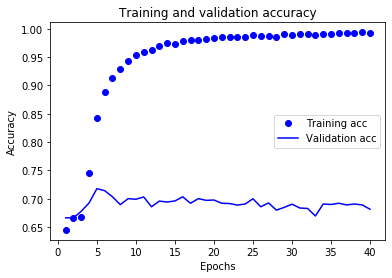

In [185]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()